# Predicting User Interaction on Reddit
#### Importing necessary libraries

In [112]:
# Webscraping
import requests
from bs4 import BeautifulSoup
import time 

# EDA/Data Mining
import pandas as pd
import numpy as np

# Modeling
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
# Setting style
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# 1. WebScraping Reddit
- Web scraping is a common technique for extracting information from websites for projects and work. Constructing a simple yet effective webscraper in Python can be achieved utilzing just two Python libraries.  
    
### _Requests Library _
- The Requests library is an elegant and simple HTPP library that accesses the raw HTML on web pages. To load a web page simply set the request equal to a response object (converts HTML to string), shown below : 

In [127]:
response = requests.get('https://old.reddit.com/')

### _Beautiful Soup Library _  
- Beautiful Soup (BS4) is a parsing library that extracts data from HTML and XML documents. Upon setting a response variable, simply access the web page's content by selecting a desired parser and setting the results equal to a soup object, shown below : 

In [128]:
soup = BeautifulSoup(response.content,'lxml')

### _Using For Loop for Multi-Page Webscrape_ 
- A for loop is used to repeat a block of code a number of times by iterating over the members of a sequence in order, executing the block each time. A for loop can be used to scrape multiple web pages containing hot threads on Reddit, the highlights from which are listed below : 
> 
   - 7200 results (   i    ) incremented by 25 (results per page)
   - Inside for loop :
        - response variable : loads each web page 
        - soup variable : parses each web page
   - Outside for loop : 
        - request_list : empty list for all scraped and parsed results to be appended to 
        - id_list: empty list for the last unique IDs to be appended to 

- Inspecting how the Reddit URL changes as additional results are generated assists in constructing a request URL that can be iterated over. Clearly seen below, each URL is comprised of a results number (count=?) and the unique ID of last result from previous page (after=?) 
> 
    - https://old.reddit.com/ 
    - https://old.reddit.com/?count=25&after=t3_8thrfw
    - https://old.reddit.com/?count=50&after=t3_8thgye


- Inspect the source code to locate the proper tags and attributes needed to grab the last unique ID on a page, the results from which will be appended to an empty list (id_list) the for loop can iterate through.

## Constructing Webscraper - https://old.reddit.com/ 

In [200]:
request_list = [] # Setting up empty list to store all results
id_list = [0]     # Setting up empty list to store each page's last unique id 


# Scraping 7200 results - increments of 25 results per page
for i in range(7100,7200,25): 
     
    # Setting request equal to response variable
    # Each URL includes
        # Results count of page being scraped "str(i)"
        # Last ID on previous page "str(id_list[-1])" - grab last ID by indexing id_list 
    response = requests.get("http://old.reddit.com/?count="+str(i)+"&after="+str(id_list[-1]), 
                 headers = {'User-agent': 'Lauren Cable-Project3-DSI-General Assembly'}) 
    
    # Parsing response variable 
    soup = BeautifulSoup(response.content, 'lxml')                           
    
    # Appending soup variable to request list 
    request_list.append(soup) 
    
    # Appending last unique ID on web page to id_list by:
        # Finding all <div> tags with attribute data-type :'link' 
        # Indexing to grab last unique ID
    id_list.append(soup.find_all('div', attrs={'data-type': 'link'})[-1]['data-fullname'])
    
    # Setting time delay before next request 
    time.sleep(.01) 
    
    # Printing URL and page being scraped 
    print(f'(http://old.reddit.com/?count=+{str(i)}+after=+{str(id_list[-1])})')
    print(i)

(http://old.reddit.com/?count=+7100+after=+t3_8tiplz)
7100
(http://old.reddit.com/?count=+7125+after=+t3_8thusz)
7125
(http://old.reddit.com/?count=+7150+after=+t3_8tj7r5)
7150
(http://old.reddit.com/?count=+7175+after=+t3_8tjn0u)
7175


## Extracting Information for Each Thread
### _Another Beautiful Soup Functionality_

- Beyond parsing web pages, BS4 can assist in navigating a parsed document to find desired data. This is accomplished by inspecting the structure of a web page's HTML source and creating functions that target certain tags, keys, and attributes. Describing this process in detail is beyond the scope of this notebook, but there are a plethora of online resources that do so.   
- Below, functions have been written to extract certain pieces of information for each hot thread on Reddit : 
---

### _Extracting all Titles_

In [201]:
def extract_title(request_list): 
    title = []   # Empty list to append all titles to 
    for i in request_list: # Iterating through request_list
        for each in i.find_all('p', attrs={'class': 'title'}): # Finding all <p> tags with attribute class: title 
            title.append(each.text)   # Appending the text from each to empty list 
    return(title)  # Output results list with titles 

# Setting function as variable
fetch_titles = extract_title(request_list)

### _Extracting all Times (length of time since posting)_

In [202]:
def extract_time(request_list):
    time = []   # Empty list to append all titles to
    for i in request_list: # Iterating through request_list
        for each in i.find_all('time'):  # Finding all <time> tags
            time.append(each.text)   # Appending the text from each to empty list
    return(time)  # Output results list with times

# Setting function as variable
fetch_times = extract_time(request_list)

# Some <time> tags are utilized as indexing results on page, signified by a '*' in the results list
# Because these results do not contain any useful data, simply remove from list 

# Mapping lambda filter on fetch_times to not include '*' results 
fetch_times = list(filter(lambda a: a != '*', fetch_times))

### _Extracting all Subreddits_

In [203]:
def extract_subreddit(request_list):
    subreddit = []  # Empty list to append all subreddits to
    for i in request_list:  # Iterating through request list 
        for each in i.find_all('a', attrs={'class': 'subreddit'}): # Finding all <a> tags with attribute class: subreddit 
            subreddit.append(each.text)  # Appending the text from each to empty list
    return(subreddit)  # Output results list with subreddits 

# Setting function as variable 
fetch_subreddit = extract_subreddit(request_list)

### _Extracting all Number of Comments_

In [204]:
def extract_number_of_comments(request_list):
    number_of_comments = []  # Empty list to append all number of comments to
    for i in request_list: # Iterating through request list 
        for each in i.find_all('a', attrs={'class': 'bylink comments may-blank'}): # Finding all <a> tags with attribute class: bylink comments may- blank                                                                        
            number_of_comments.append(each.text)  # Appending the text from each to empty list
    return(number_of_comments)  # Output results list with number of comments 

# Setting function as variable 
fetch_number_of_comments = extract_number_of_comments(request_list)

## Transforming results into dataframe and saving as CSV
---

In [205]:
# Transorming each variable from above into column on dataframe
df = pd.DataFrame({'Title':fetch_titles,
                   'Time': fetch_times, 
                   'Subreddit': fetch_subreddit, 
                   'Comments':fetch_number_of_comments})

# Saving and exporting dataframe as csv
df.to_csv('scrapeddata.csv',index=False)

# 2. Exploratory Data Analysis

### _Loading in scraped results_

In [336]:
df = pd.read_csv('scrapeddata.csv')  # Loading in exported csv with Pandas
df.head(10)                          # Printing the first 10 rows 

,Unnamed: 0,Comments,Subreddit,Time,Title
0,0,715 comments,r/funny,3 hours ago,Well...can anyone tell me the answer? (i.redd.it)
1,1,642 comments,r/mildlyinteresting,3 hours ago,We have a Party City coming soon. Next to Part...
2,2,1118 comments,r/oddlysatisfying,4 hours ago,Fun at work with 1377 pallets (i.imgur.com)
3,3,1359 comments,r/Showerthoughts,4 hours ago,Your future self is talking shit about you (se...
4,4,129 comments,r/BlackPeopleTwitter,5 hours ago,Until his daughter gets kidnapped again. (i.im...
5,5,257 comments,r/woahdude,5 hours ago,The Skeleton Flower’s petals become transparen...
6,6,63 comments,r/funny,3 hours ago,Get her told Frank (i.redd.it)
7,7,556 comments,r/TwoXChromosomes,3 hours ago,I called the police. Just need to vent./r/all ...
8,8,693 comments,r/pics,5 hours ago,Flying into Bora Bora (i.redd.it)
9,9,145 comments,r/todayilearned,3 hours ago,"TIL all ""warranty void if removed"" stickers ar..."


### _Checking for nulls & duplicated values_ 

In [337]:
df.isnull().sum()       # There are no missing values 

Unnamed: 0    0
Comments      0
Subreddit     0
Time          0
Title         0
dtype: int64

In [338]:
df.duplicated().sum()   # There are no duplicated values 

0

In [339]:
df.drop('Unnamed: 0',axis=1,inplace=True) # Dropping duplicate indexing column

### _Checking datatypes_
- Data types reveal how information is embedded into each column of a dataframe and can take the form of integer, float, object, etc. to name a few.
- Because the Number of Comments and Time columns are numerical data they will both need to be reassigned as a  `float`

In [340]:
df.dtypes  # Printing datatypes 

Comments     object
Subreddit    object
Time         object
Title        object
dtype: object

In [341]:
# Converting numerical columns to floats 

# Removing non-numeric values with regular expression
df['Comments'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
df['Time'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

# Converting to float
df['Comments'] = df['Comments'].astype(float)
df['Time'] = df['Time'].astype(float)

# Inspecting progress
df.head(2)

,Comments,Subreddit,Time,Title
0,715.0,r/funny,3.0,Well...can anyone tell me the answer? (i.redd.it)
1,642.0,r/mildlyinteresting,3.0,We have a Party City coming soon. Next to Part...


### _Preparing for Classification Models - Predicting a Binary Variable_ 
- To identify features that result in more user interaction, models must predict when threads will have a high number of comments. This can be accomplished by converting target data (Number of Comments) into a binary classification problem (1 or 0, representing High or Low Comments)
- Determining the cut-off value requires investigating the target variable's distribution, shown via the histogram below : 

(array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
        0.004 , 0.0045]), <a list of 10 Text yticklabel objects>)

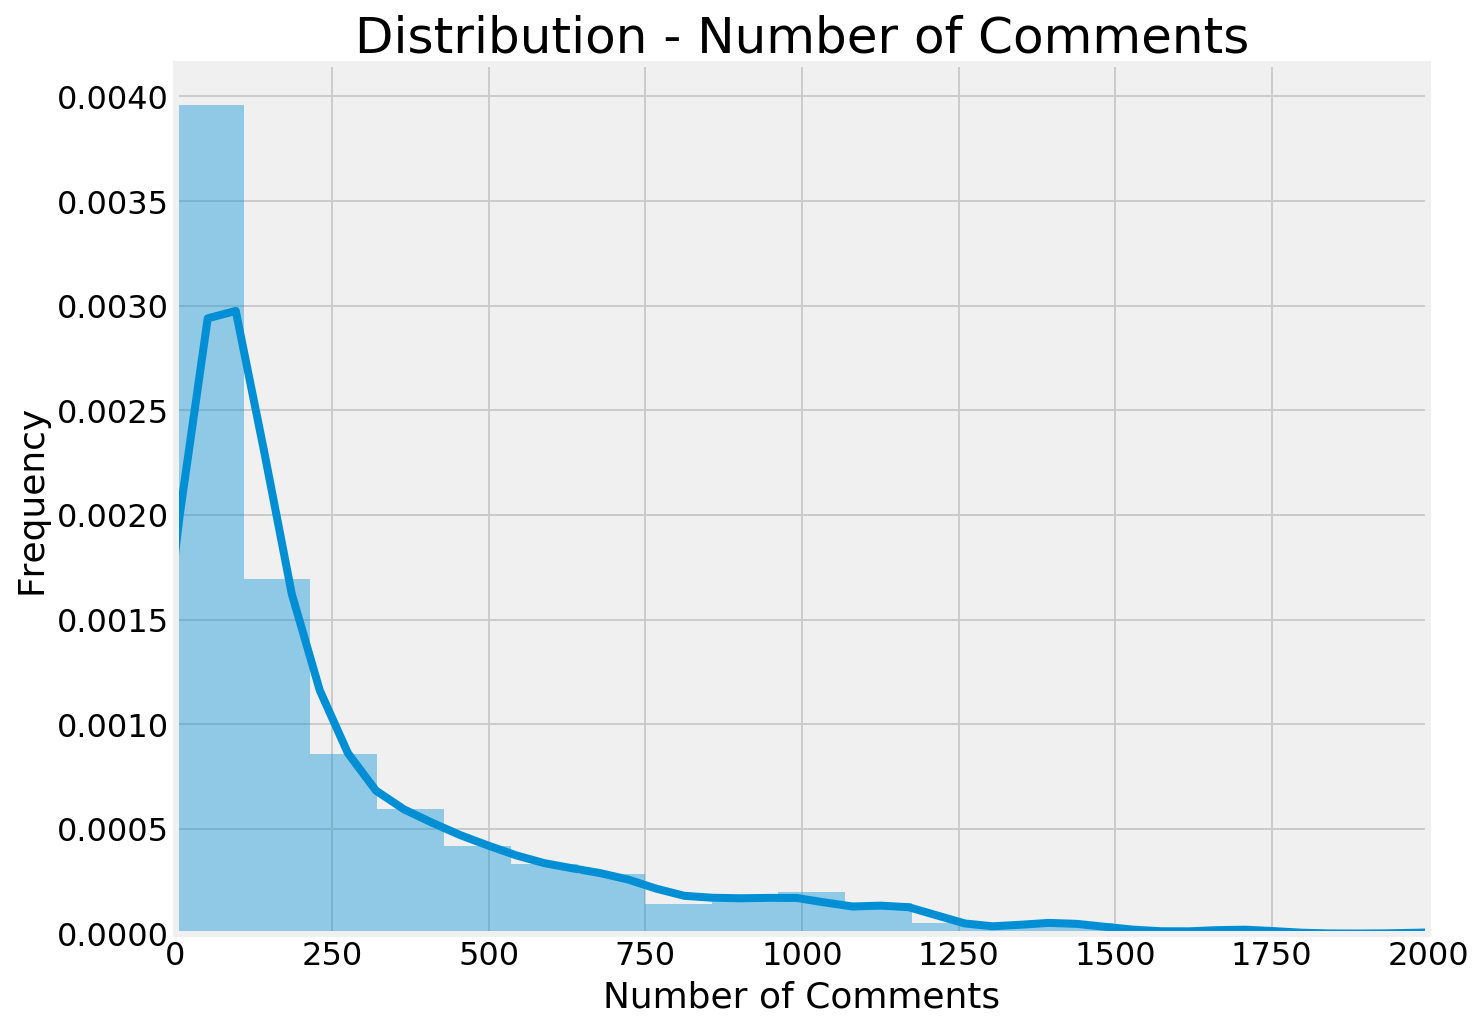

In [342]:
plt.figure(figsize=(10,8))   
sns.distplot(df['Comments'])
plt.xlim(0,2000)
plt.title('Distribution - Number of Comments',fontsize=25)
plt.xlabel('Number of Comments',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

- The data clearly has a heavy positive skew, indicating that the majority of Reddit posts will have a low number of comments.
- More importantly, the skewed distributionn means that simply using the average as the basis for class division (High or Low Commennts) will not be satisfactory. To divide the data more effectively the 75th percentile should be utilized, which can be produced by printing summary statistics, shown below: 

In [343]:
# Printing summary stats to find value for 75th percentile - to be used to divide data into binary variable  
    # 418 Comments 
df['Comments'].describe() 

count    2529.000000
mean      371.464215
std       583.299742
min         2.000000
25%        63.000000
50%       143.000000
75%       418.000000
max      5338.000000
Name: Comments, dtype: float64

### _Transforming Target Variable into Binary Classifcation Problem_ 
> 
- Target Variable = Number of Comments
- Cut-off = 418 Comments 
    - 0 signifies Low Comments
    - 1 signifies High Comments 


In [344]:
# Creating new binary column in dataframe by mapping lambda function to Number of Comments 
df['Comment Dummy'] = df['Comments'].map(lambda x: 1 if x > 418.00 else 0)

# Inspecting progress
df.head(2)

,Comments,Subreddit,Time,Title,Comment Dummy
0,715.0,r/funny,3.0,Well...can anyone tell me the answer? (i.redd.it),1
1,642.0,r/mildlyinteresting,3.0,We have a Party City coming soon. Next to Part...,1


### _Determining Baseline Accuracy by Inspecting Class Attributes_
- `Baseline` `Accuracy` is a simple summary statistic (average) used as a point of reference to consider whether or not value is being added to model by machine learning algorithms.
- For classification models, the average for the class the model seeks to predict (High Comments in this notebook) is utilized. 
- NOTE : If the baseline statistic is not the majority class, this average needs to be subtracted from 1. Thus, determining baseline accuracy must begin by first inspecting whether or not classes are balanced, shown below : 

In [345]:
# Inspecting how balanced classes are by looking at value counts 
print('==================================')
print('Value Counts:')
print(df['Comment Dummy'].value_counts())
print('==================================')

Value Counts:
0    1897
1     632
Name: Comment Dummy, dtype: int64


(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.]),
 <a list of 9 Text yticklabel objects>)

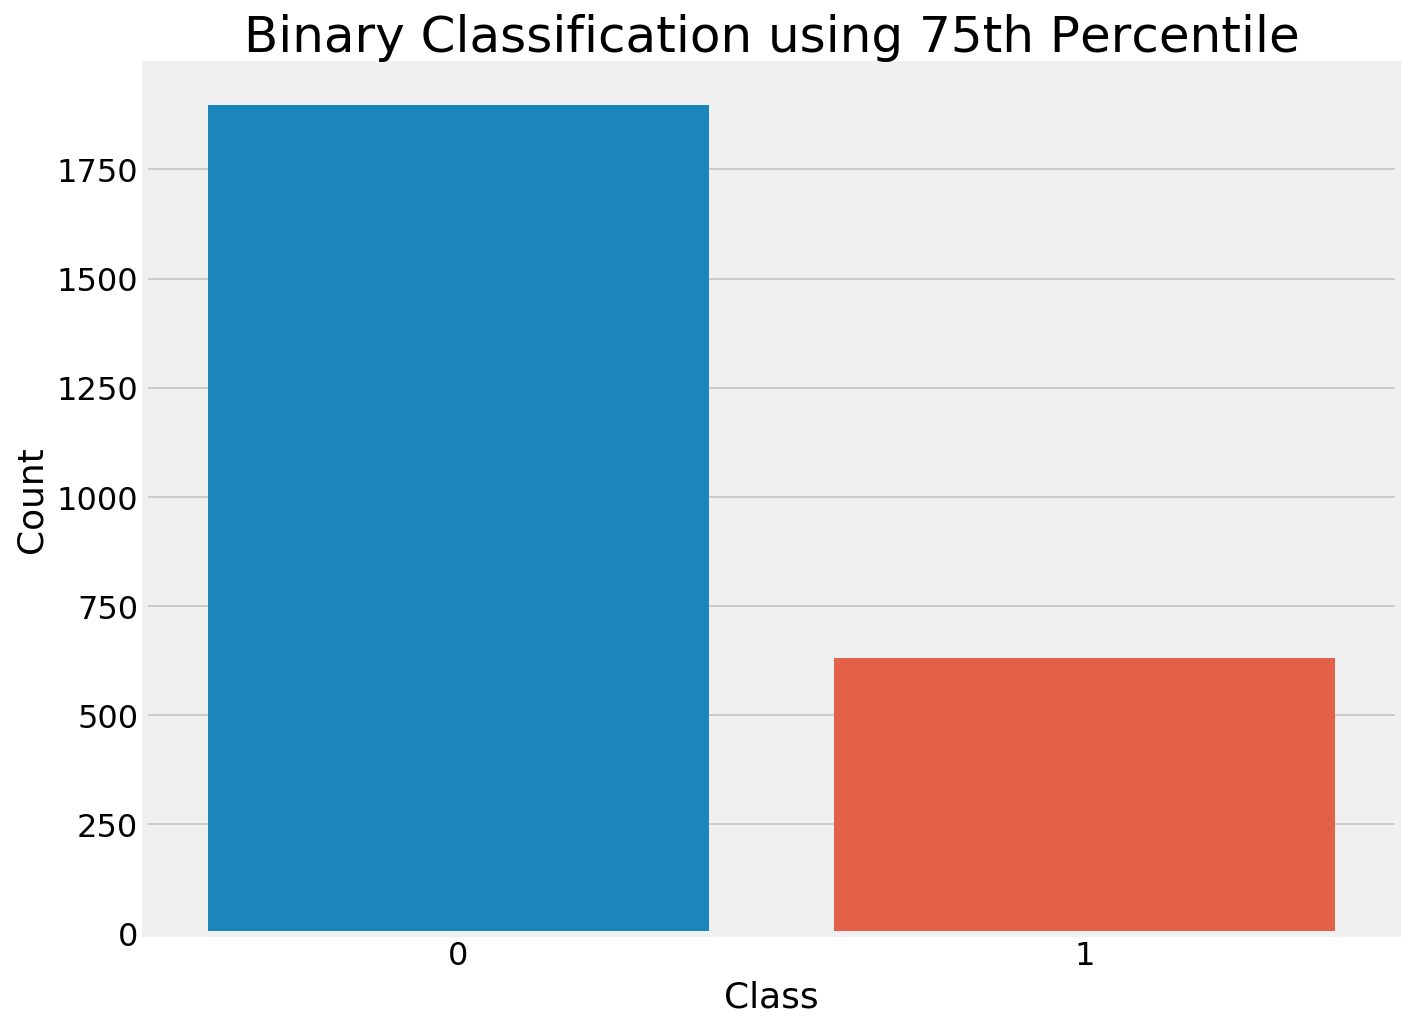

In [346]:
# Plotting bar graph to visualize 

plt.figure(figsize=(10,8)) # Plotting bar graph to visualize
sns.countplot(x="Comment Dummy", data=df)
plt.title('Count- High/Low Comments',fontsize=18)
plt.title('Binary Classification using 75th Percentile',fontsize=25)
plt.xlabel('Class',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [347]:
# Because classes are not balanced

baseline = 1 - df['Comment Dummy'].mean()
print('=================================================================')
print('Baseline Accuracy: ',baseline)
print('This is the accuracy our modeling techniques seek to improve on')
print('=================================================================')

Baseline Accuracy:  0.7500988533017003
This is the accuracy our modeling techniques seek to improve on


# 3. Model Building

- The model building process focuses on predicting when a hot thread on Reddit will receive a high number of comments by utilizing different features from the webscraped and formatted data above as predictor variables. Each model built follows the same core steps, listed below : 
> 
   - Splitting data into training/testing sets
   - Fitting models on training data
   - Making predictions on testing data
   - Evaluating model using performance metrics  

## Count Vectorizer w/ Random Forest Model 
### _Utilizing Title as Predictor Variable_

- A `Count` `Vectorizer` is a useful tool for transforming unstructured text data into structured data by converting a collection of text documents into a matrix of token counts, represented as a sparse matrix. 
- A `Random` `Forest` model is a popular, supervised classification algorithm that tries to solve problems using tree representation - each internal node of the tree corresponds to an attribute, and each leaf node corresponds to a class label.
- Below, the Title column/feature is count vectorized and transformed into a sparse matrix, which is then utilized as the predictor matrix and fed into a Random Forest model to predict high number of comments. To reduce overfitting (variance), a 5-folds `Cross` `Validation` was performed, which splits training data into n-folds different groups to predict the target variable and deliver more accurate results. `Feature` `Importances` aka model coefficient strengths are then accessed to reveal what title words are most predictive of a Reddit post receiving high comments.   

### _Count Vectorizing Title_

In [348]:
# Defining predictor/target variables
X = df['Title']             
y = df['Comment Dummy']     

# Instantiating Count Vectorizer and removing english stopwords - set of common words that add little value to model
cv = CountVectorizer(stop_words='english')

# Splitting data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

# Fitting Count Vectorizer - teaching model vocabularly 
cv.fit(X_train)

# Mapping selected data to vocabulary
# Transforming training/testing sets to dataframes 
Xs_train = pd.DataFrame(cv.transform(X_train).todense(), columns=cv.get_feature_names())
Xs_test = pd.DataFrame(cv.transform(X_test).todense(), columns=cv.get_feature_names())

### _Building Random Forest Model_

In [349]:
# Instantiating Random Forest Classifier
cvec_rf = RandomForestClassifier()

# Fitting model on training data 
cvec_rf.fit(Xs_train, y_train)

# Making preidctions on testing data 
preds = cvec_rf.predict(Xs_test)

# Scoring model
score = cvec_rf.score(Xs_test,y_test)

# Cross-validating scores
cvs = cross_val_score(cvec_rf, Xs_test, y_test, cv=5).mean()

# Printing baseline accuracy and scores
print('Baseline Accuracy: ' , baseline)
print('Random Forest w/Title Words- Score: ', score)
print('Random Forest w/Title Words- 5 Folds CV Score: ', cvs)

Baseline Accuracy:  0.7500988533017003
Random Forest w/Title Words- Score:  0.9841897233201581
Random Forest w/Title Words- 5 Folds CV Score:  0.8381176470588235


### _---> 9% Improvement on Baseline Accuracy <---_

### _Identifying Predictive Title Words - Accessing Model Feature Importances_

In [350]:
feature_importances = pd.DataFrame(cvec_rf.feature_importances_,
                                   index = Xs_test.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_importances.sort_values('importance', ascending=False).head(10)

,feature,importance
403,dontbelikeyahoo,0.025055
189,bora,0.020526
995,peekaboo,0.020508
184,boink,0.019963
544,games,0.018617
408,drinking,0.017759
295,coming,0.016994
1338,thinking,0.015506
1275,starterpack,0.015373
160,bentley,0.015080


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

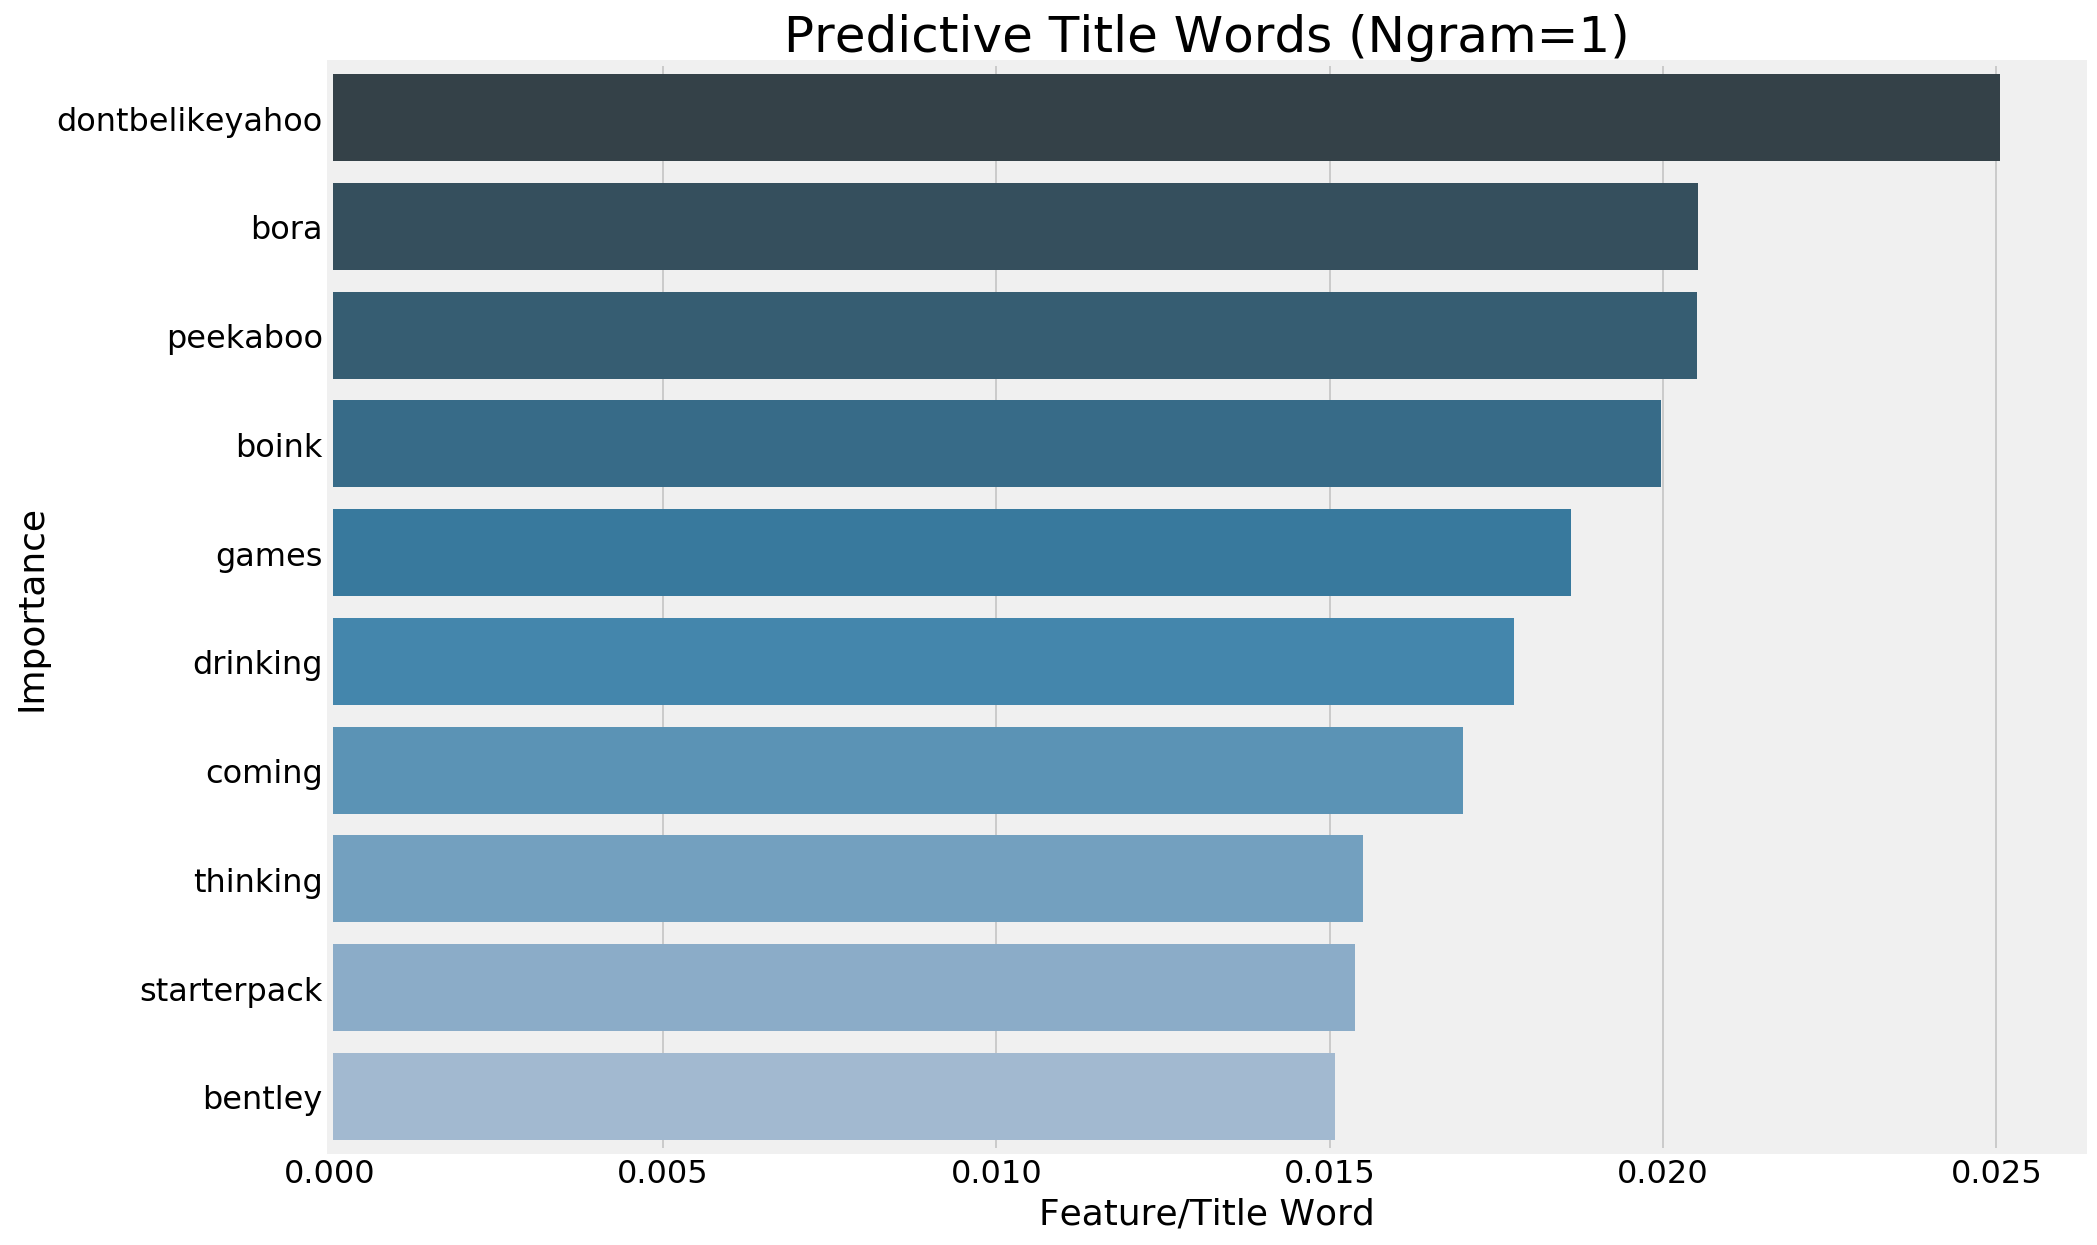

In [351]:
# Plotting bar graph to visualize

plt.figure(figsize=(14,10))
sns.barplot(y = feature_importances.sort_values('importance', ascending=False).head(10)['feature'],
            x = feature_importances.sort_values('importance', ascending=False).head(10)['importance'], 
            palette = 'PuBu_d')
plt.title('Predictive Title Words (Ngram=1)',fontsize=25)
plt.xlabel('Feature/Title Word',fontsize=18)
plt.ylabel('Importance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Tuning Count Vectorizer Parameters : N-Gram
- An N-Gram is a contiguous sequence of n items from a given sample of text that can reveal patterns overlooked by simple word count analyses. To demonstrate, notice how varying n-gram lengths offer different meaning for the sentence "I love cats" : 
> N-gram = 1 
         - 'I'
         - 'love'
         - 'cats'
> N-gram = 2 
         - 'I love' 
         - 'love cats'
> N-gram = 3 
         - 'I love cats'
         
- Running the Random Forest model while tuning this parameter will reveal additional predictive patterns of Title words, shown below :

## N-Gram Range = 2
### _Count Vectorizing Title_

In [352]:
# Defining predictor/target variables
X = df['Title']             
y = df['Comment Dummy']    


# Instantiating Count Vectorizer and removing english stopwords - set of common words that add little value to model
cv = CountVectorizer(stop_words='english',ngram_range= (2,2)) # Setting n-gram range to 2x2 vector 

# Splitting data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

# Fitting Count Vectorizer - teaching model vocabularly 
cv.fit(X_train)

# Mapping selected data to vocabulary
# Transforming training/testing sets to dataframes 
Xs_train = pd.DataFrame(cv.transform(X_train).todense(), columns=cv.get_feature_names())
Xs_test = pd.DataFrame(cv.transform(X_test).todense(), columns=cv.get_feature_names())

### _Building Random Forest Model_

In [353]:
# Instantiating Random Forest Classifier
cvec_rf = RandomForestClassifier()

# Fitting model on training dat
cvec_rf.fit(Xs_train, y_train)

# Making preidctions on testing data 
preds = cvec_rf.predict(Xs_test)

# Scoring model
score = cvec_rf.score(Xs_test,y_test)

# Cross-validating scores
cvs = cross_val_score(cvec_rf, Xs_test, y_test, cv=5).mean()

# Printing baseline accuracy and scores 
print('Baseline Accuracy: ' , baseline)
print('Random Forest w/BiGram Title Words- Score: ', score)
print('Random Forest w/BiGram Title Words- 5 Folds CV Score: ', cvs)

Baseline Accuracy:  0.7500988533017003
Random Forest w/BiGram Title Words- Score:  0.9762845849802372
Random Forest w/BiGram Title Words- 5 Folds CV Score:  0.8774690799396682


### _---> 13 % Improvement on Baseline Accuracy <--- _

### _Identifying Predictive Title Words - Accessing Model Feature Importances_

In [354]:
feature_importances = pd.DataFrame(cvec_rf.feature_importances_,
                                   index = Xs_test.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_importances.sort_values('importance', ascending=False).head(10)

,feature,importance
509,dontbelikeyahoo redd,0.037863
231,boink imgur,0.021840
364,coming soon,0.019516
1302,peekaboo gfycat,0.017887
116,announcement photo,0.014804
1477,republicans real,0.013984
193,bentley redd,0.012889
1408,property house,0.012314
120,answer redd,0.011746
1235,offroad bentley,0.011708


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

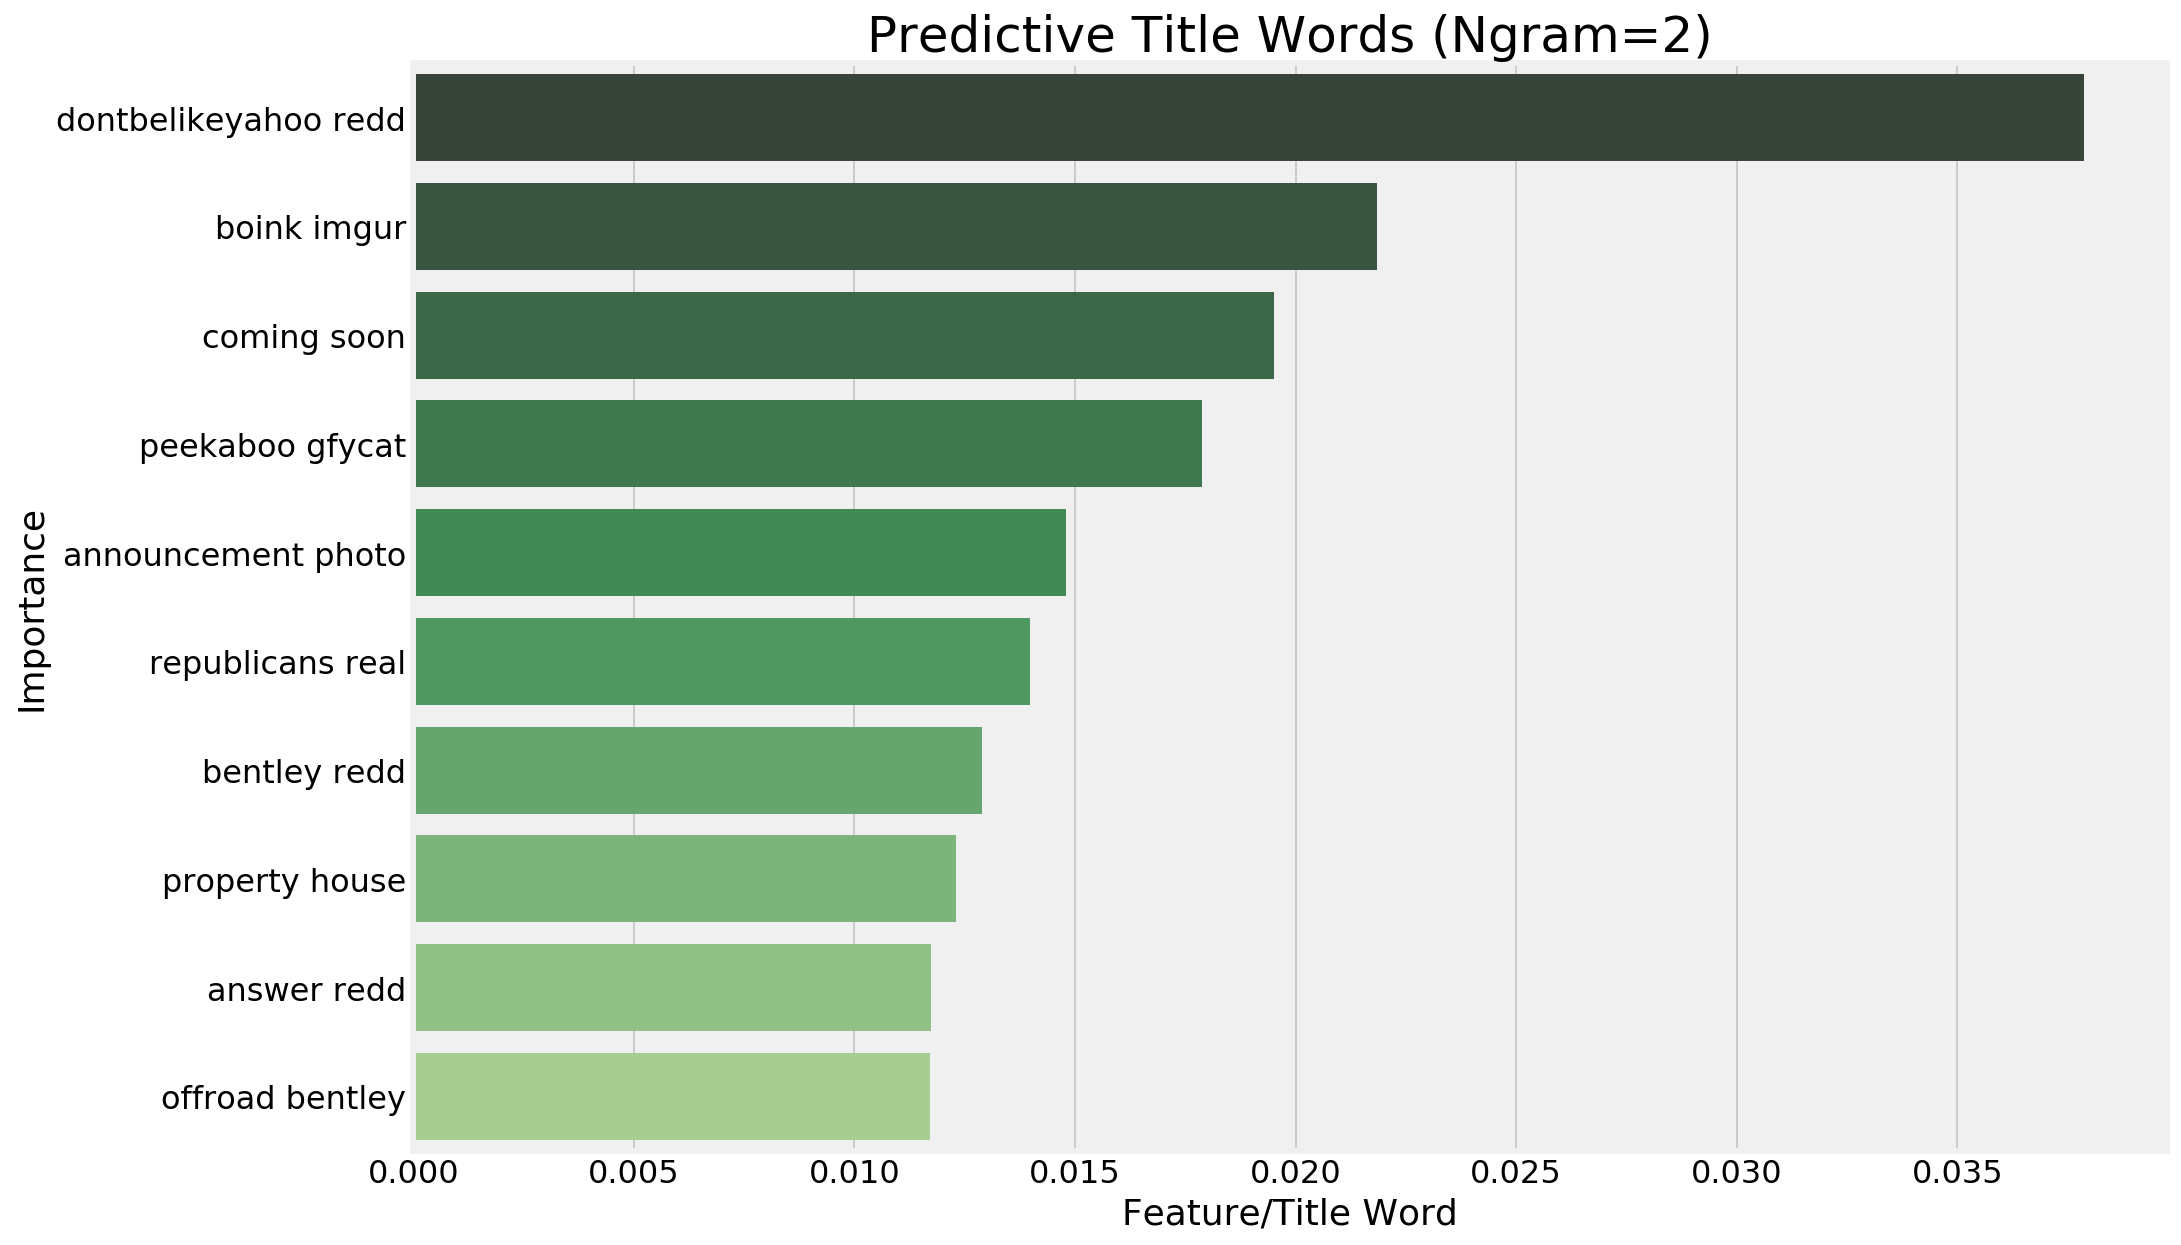

In [355]:
# Plotting bar graph to visualize 

plt.figure(figsize=(14,10))
sns.barplot(y = feature_importances.sort_values('importance', ascending=False).head(10)['feature'],
            x = feature_importances.sort_values('importance', ascending=False).head(10)['importance'],
           palette = 'YlGn_d')
plt.title('Predictive Title Words (Ngram=2)',fontsize=25)
plt.xlabel('Feature/Title Word',fontsize=18)
plt.ylabel('Importance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## N-Gram Range = 3
### _Count Vectorizing Title_

In [356]:
# Defining predictor/target variables
X = df['Title']             
y = df['Comment Dummy']    


# Instantiating Count Vectorizer and removing english stopwords - set of common words that add little value to model
cv = CountVectorizer(stop_words='english',ngram_range= (3,3)) # Setting n-gram range to 3x3 vector 

# Splitting data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

# Fitting Count Vectorizer - teaching model vocabularly 
cv.fit(X_train)

# Mapping selected data to vocabulary
# Transforming training/testing sets to dataframes 
Xs_train = pd.DataFrame(cv.transform(X_train).todense(), columns=cv.get_feature_names())
Xs_test = pd.DataFrame(cv.transform(X_test).todense(), columns=cv.get_feature_names())

### _Building Random Forest Model_

In [357]:
# Instantiating Random Forest Classifier
cvec_rf = RandomForestClassifier()

# Fitting model on training data 
cvec_rf.fit(Xs_train, y_train)

# Making preidctions on testing data 
preds = cvec_rf.predict(Xs_test)

# Scoring model
score = cvec_rf.score(Xs_test,y_test)

# Cross-validating scores
cvs = cross_val_score(cvec_rf, Xs_test, y_test, cv=5).mean()

# Printing baseline accuracy and scores 
print('Baseline Accuracy: ' , baseline)
print('Random Forest w/BiGram Title Words- Score: ', score)
print('Random Forest w/BiGram Title Words- 5 Folds CV Score: ', cvs)

Baseline Accuracy:  0.7500988533017003
Random Forest w/BiGram Title Words- Score:  0.9802371541501976
Random Forest w/BiGram Title Words- 5 Folds CV Score:  0.8457254901960785


### _---> 15% Improvement on Baseline Accuracy<---_

### _Identifying Predictive Title Words - Accessing Model Feature Importances_

In [358]:
feature_importances = pd.DataFrame(cvec_rf.feature_importances_,
                                   index = Xs_test.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_importances.sort_values('importance', ascending=False).head(10)

,feature,importance
1079,offroad bentley redd,0.028079
451,drinking alcohol redd,0.025559
148,basement starterpack redd,0.024571
1510,tell answer redd,0.022818
199,boink imgur com,0.022295
1138,peekaboo gfycat com,0.019967
1151,personal property house,0.019704
1212,pregnancy announcement photo,0.015037
996,mom shops online,0.014531
270,catch gfycat com,0.012659


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

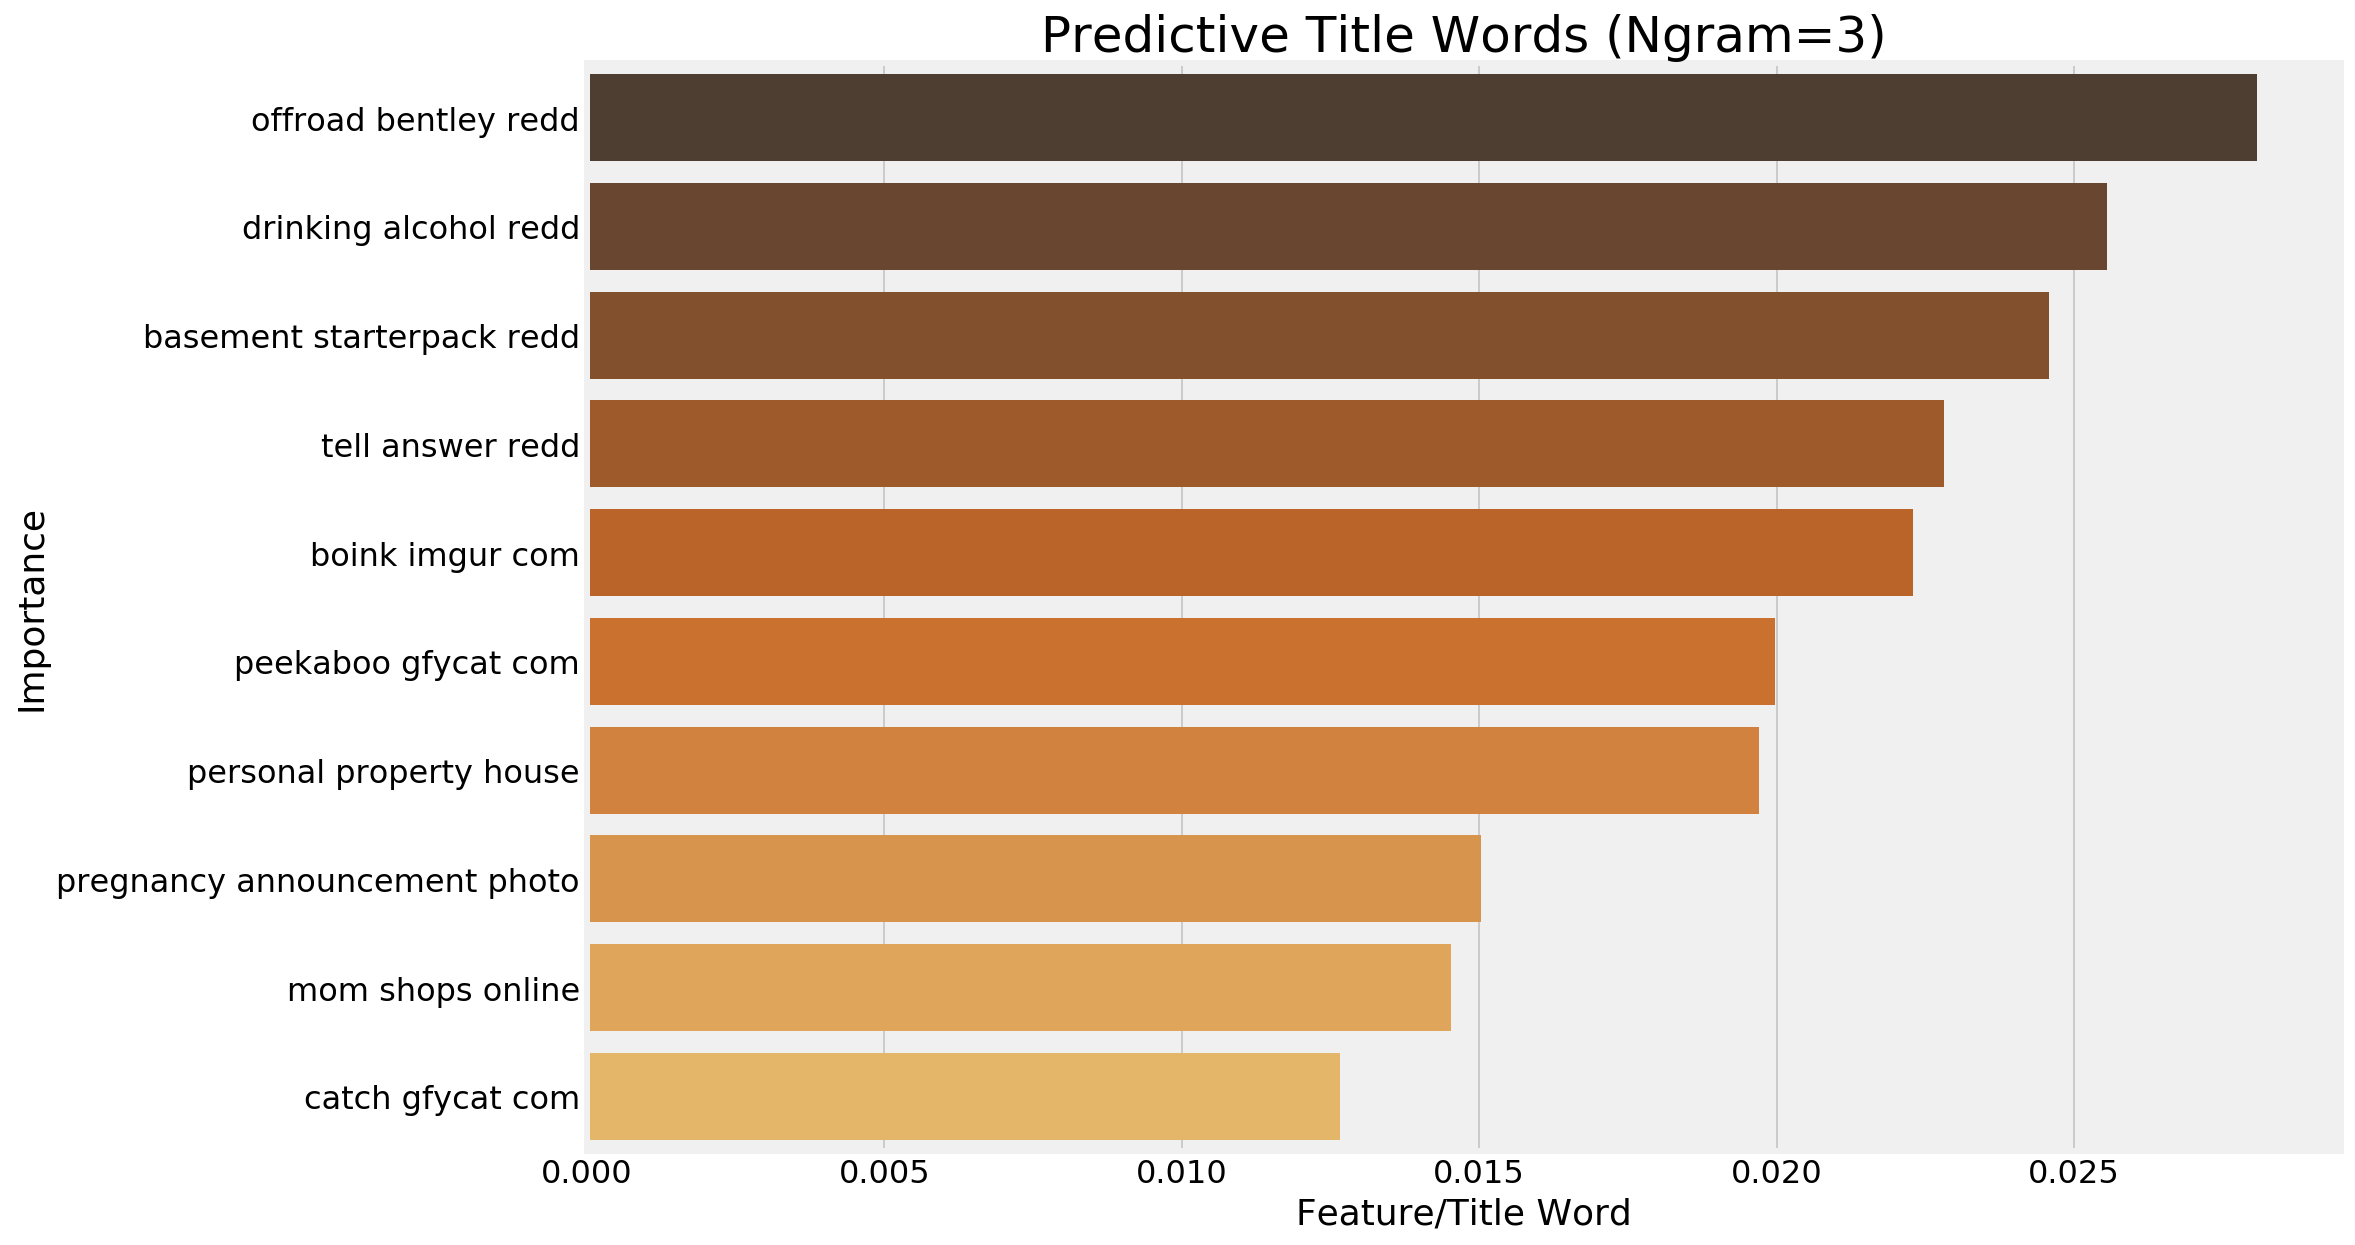

In [359]:
# Plotting bar graph to visualize 

plt.figure(figsize=(14,10))
sns.barplot(y = feature_importances.sort_values('importance', ascending=False).head(10)['feature'],
            x = feature_importances.sort_values('importance', ascending=False).head(10)['importance'],
           palette = 'YlOrBr_d')
plt.title('Predictive Title Words (Ngram=3)',fontsize=25)
plt.xlabel('Feature/Title Word',fontsize=18)
plt.ylabel('Importance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Dummy Variable w/ Random Forest Model 
### _Utilizing Subreddit as Predictor Variable_
- A `Dummy` `Variable` is used in regression analysis by quantifying categorical variables that do not have any relationship. While the terms dummy variables and binary variable are sometimes used interchangably (both 1s and 0s), they are not exactly the same thing.  
- Below, the Subreddit column/feature is transformed into a dummy variable, represented by a sparse matrix with a binary column for each individual Subreddit, which is then utilized as the predictor matrix and fed into a Random Forest model to predict high number of comments. Once againn, a 5-folds cross validation score is determined to reduce overfitting and feature importances are accessed to reveal which Subreddits are most predictive of a post having high comments. 

### _Creating Dummy Variable for Subreddit_

In [360]:
subreddit_dummy = pd.get_dummies(df['Subreddit'])  
subreddit_dummy.head(5)

,r/2meirl4meirl,r/AbandonedPorn,r/AbsoluteUnits,r/AnimalsBeingBros,r/AnimalsBeingDerps,r/AnimalsBeingJerks,r/Art,r/AskOuija,r/AskReddit,r/Astronomy,...,r/wholesomegifs,r/wholesomememes,r/woahdude,r/woof_irl,r/woooosh,r/worldbuilding,r/worldcup,r/worldnews,r/youdontsurf,r/youseeingthisshit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [361]:
# Defining predictor/target variables
x = subreddit_dummy                    
y = df['Comment Dummy']                

# Instantiating Random Forest Model
rf1 = RandomForestClassifier()

# Splitting data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

# Fitting model on training data  
rf1.fit(X_train,y_train)

# Making predictions on testing data 
rf1_preds = rf1.predict(X_test)

# Scoring model 
rf1_score = rf1.score(X_test,y_test)

# Cross validating scores 
cv1_score = cross_val_score(rf1,X_test,y_test,cv=5).mean()

# Printing baseline accuracy and scores
print('Baseline Accuracy: ' , baseline)
print('Random Forest w/TriGram Title Words- Score: ', rf1_score)
print('Random Forest w/TriGram Title Words- 5 Folds CV Score: ', cv1_score)

Baseline Accuracy:  0.7500988533017003
Random Forest w/TriGram Title Words- Score:  0.9011857707509882
Random Forest w/TriGram Title Words- 5 Folds CV Score:  0.8337797888386124


### _---> 13% Improvement on Baseline Accuracy <---_

### _Identifying Predictive Subreddits - Accessing Model Feature Importances_

In [362]:
feature_importances = pd.DataFrame(rf1.feature_importances_,
                                   index = X_test.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_importances.sort_values('importance', ascending=False).head(10)

,feature,importance
235,r/worldnews,0.108099
182,r/news,0.091035
193,r/pics,0.041702
151,r/gatekeeping,0.039493
189,r/oddlysatisfying,0.035262
221,r/trashy,0.033508
84,r/PoliticalHumor,0.032698
214,r/technology,0.032385
132,r/dataisbeautiful,0.032009
190,r/oldpeoplefacebook,0.028528


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

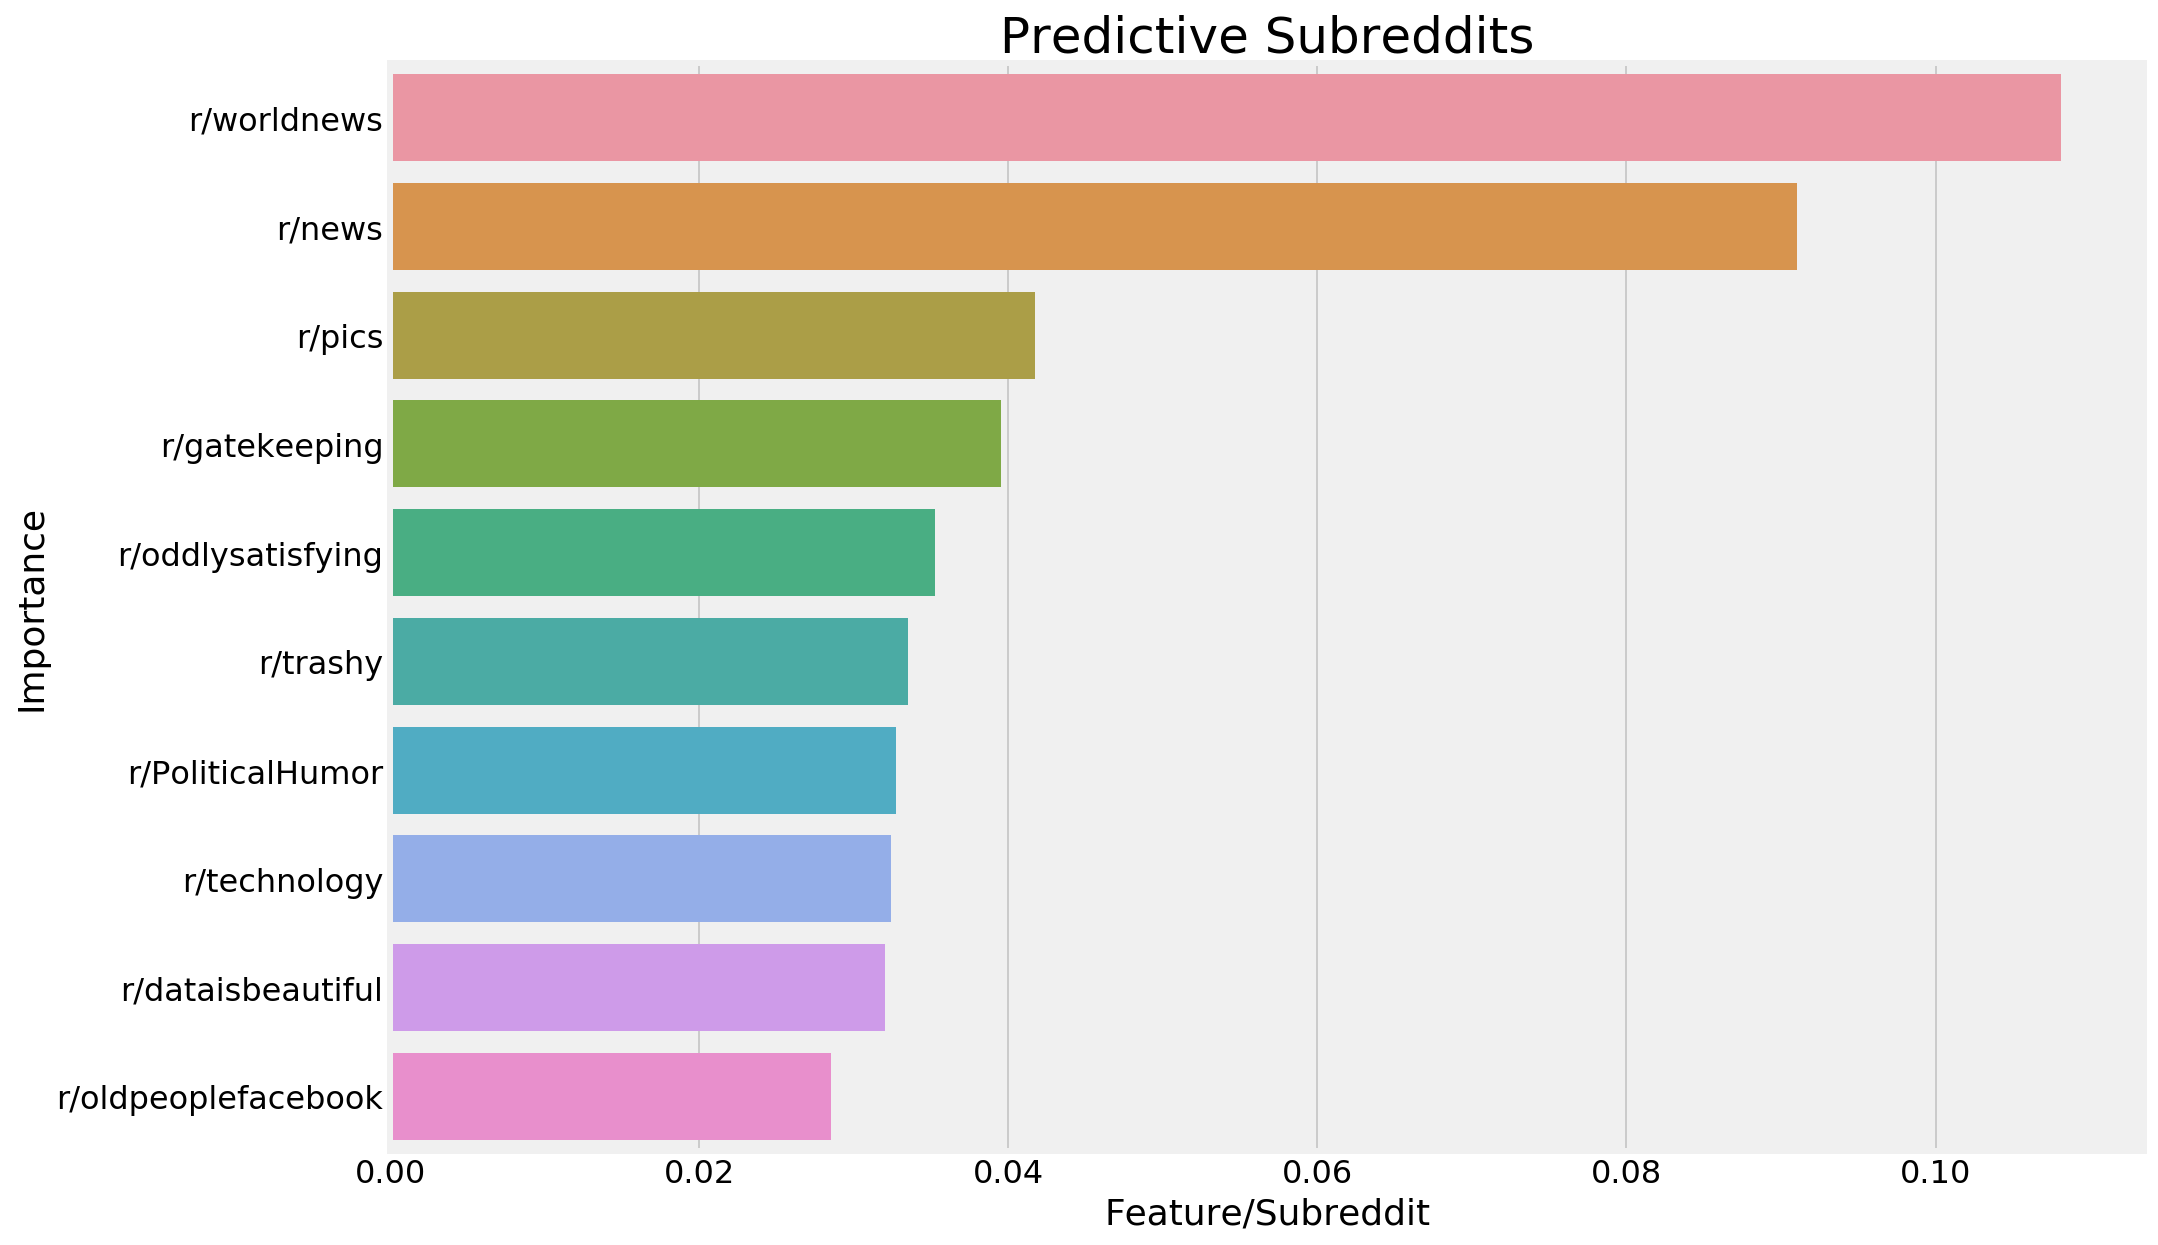

In [363]:
# Plotting bar graph to visualize

plt.figure(figsize=(14,10))
sns.barplot(y = feature_importances.sort_values('importance', ascending=False).head(10)['feature'],
           x = feature_importances.sort_values('importance', ascending=False).head(10)['importance'])
plt.title('Predictive Subreddits',fontsize=25)
plt.xlabel('Feature/Subreddit',fontsize=18)
plt.ylabel('Importance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### _Investigating Predictive Subreddits_

- The modelling above identified the following Subreddits to be the most predictive of high comments for a hot thread on Reddit :
> - `r/worldnews`
> - `r/news`
> - `r/pics` 

- By taking a look at attributes for posts from these Subreddits, specifically the amount of times they received a high number of comments and the average length of time they were up on Reddit, some insight into the relationship between time and user interaction can be provided. Below, the dataframe has been subsetted for the top 3 most predictive Subreddits in order to then access said attributes : 

### _r/worldnews_

In [364]:
worldnews = df[df['Subreddit']=='r/worldnews'] # Subsetting DataFrame to only include 'r/worldnews' Subreddit

high_comments = worldnews['Comment Dummy'].count() # Calculating # of posts receiving high number of comments 
avg_time = worldnews['Time'].mean()                # Calculating avg time posts on Reddit

# Printing results
print("High Comments Threads Predicted: ",high_comments)
print("Avg. Time on Reddit  : " ,avg_time) 

High Comments Threads Predicted:  50
Avg. Time on Reddit  :  7.72


### _r/news_

In [365]:
news = df[df['Subreddit']=='r/news'] # Subsetting DataFrame to only include 'r/news' Subreddit

high_comments = news['Comment Dummy'].count()      # Calculating # of posts receiving high number of comments 
avg_time = news['Time'].mean()                     # Calculating avg time posts on Reddit

# Printing results
print("High Comments Threads Predicted: ",high_comments)
print("Avg. Time on Reddit  : " ,avg_time) 

High Comments Threads Predicted:  47
Avg. Time on Reddit  :  9.23404255319149


### _r/pics_

In [366]:
pics = df[df['Subreddit']=='r/pics'] # Subsetting DataFrame to only include 'r/pics' Subreddit

high_comments = pics['Comment Dummy'].count()      # Calculating # of posts receiving high number of comments 
avg_time = pics['Time'].mean()                     # Calculating avg time posts on Reddit

# Printing results
print("High Comments Threads Predicted: ",high_comments)
print("Avg. Time on Reddit  : " ,avg_time) 

High Comments Threads Predicted:  135
Avg. Time on Reddit  :  6.4148148148148145


- It seems as though somewhere in the 6th hour is the most predictive time in terms of high comment posts for Reddit hot threads, which can be investigating further by plotting average times for all posts with high comments

In [367]:
high_comments = df[df['Comment Dummy']==1]  # Subsetting dataframe to only include posts receiving high comments 

# Grouping posts together by hourly time brackets and sorting by count of high comment threads 
high_comments.groupby('Time').sum().sort_values('Comment Dummy',ascending=False).head(5)

,Comments,Comment Dummy
Time,,
7.0,132550.0,122
9.0,120165.0,115
6.0,75776.0,96
5.0,79619.0,80
8.0,70441.0,53


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 8 Text yticklabel objects>)

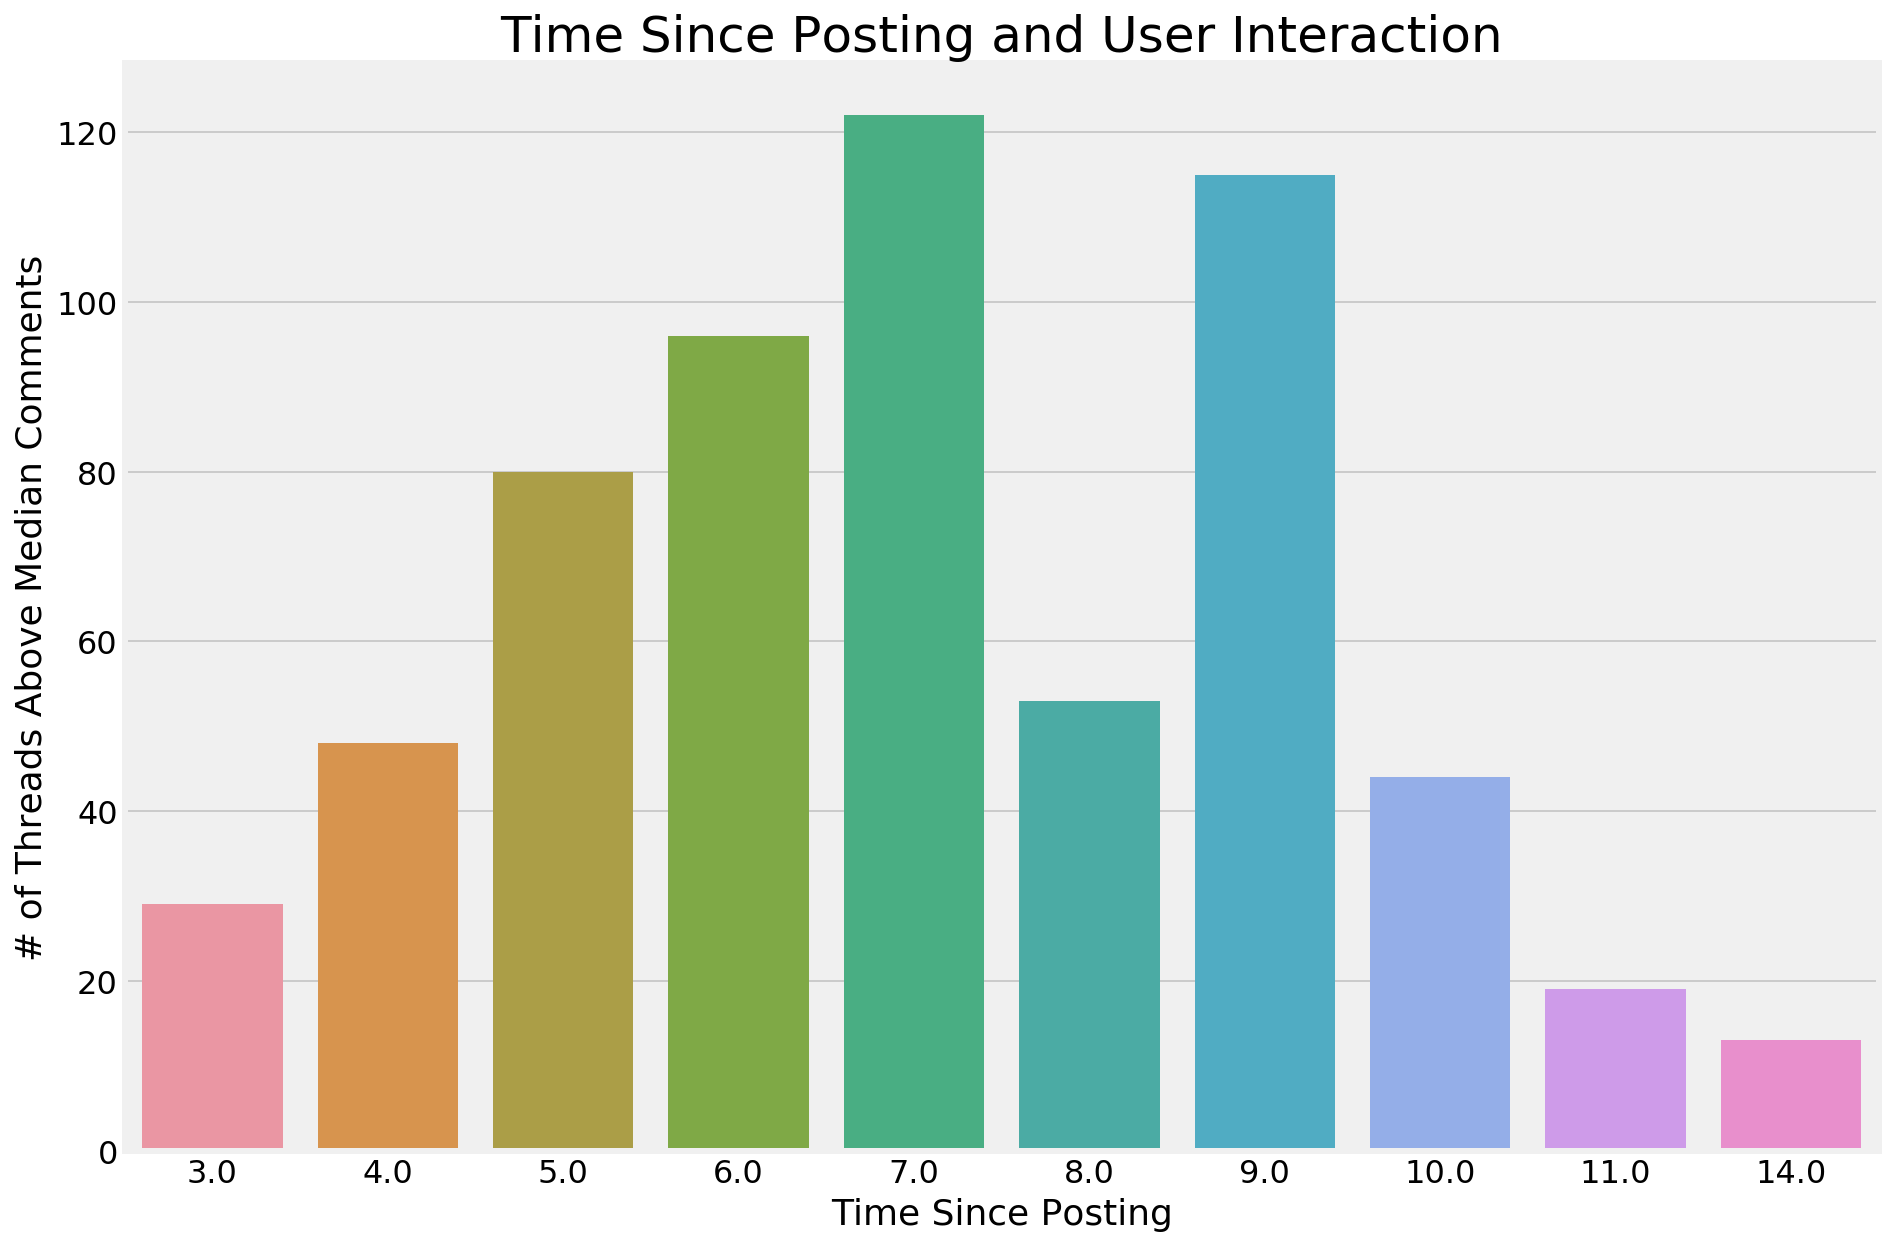

In [368]:
# Creating bar plot to visualizize 

top_times = high_comments.groupby('Time').sum().sort_values('Comment Dummy',ascending=False).head(10)

x = top_times.index
y = top_times['Comment Dummy']

plt.figure(figsize=(14,10))
sns.barplot(x,y)
plt.title('Time Since Posting and User Interaction',fontsize=25)
plt.ylabel('# of Threads Above Median Comments',fontsize=18)
plt.xlabel('Time Since Posting',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Dummy Variable w/ Logistic Regression Model 
### _Utilizing Subreddit as Predictor Variable_
- A `Logistic` `Regression` model is used to describe data and explain the relationship between one dependent binary variable and one or more independent variables.  
- Below, the Subreddit Dummy Variable is again utilized as the predictor matrix and fed into a Logistic Regression model to predict high number of comments. Once again, a 5-folds cross validation score is determined to reduce overfitting.
- Additional metrics are then leveraged to further judge model performance by way of confusion matrices 

### _Building Logistic Regression Model_

In [369]:
# Defining predictor/target variables
X = pd.get_dummies(df['Subreddit'])    
y = df['Comment Dummy']                

# Instantiating Logistic Regression Model 
lr1 = LogisticRegression()

# Splitting data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Fitting model on training data 
lr1.fit(X_train,y_train)

# Making predictions on testing data
lr1_preds = lr1.predict(X_test)

# Scoring model 
lr1_score = lr1.score(X_test,y_test)

# Cross-validating scores
cv1_score = cross_val_score(lr1,X_test,y_test,cv=5).mean()

# Printing baseline accuracy and scores
print('Baseline Accuracy: ' , baseline)
print('Logistic Regression- Subreddit- Score: ',lr1_score)
print('Logistic Regression- Subreddit- CV Score (5 Folds): ',cv1_score)

Baseline Accuracy:  0.7500988533017003
Logistic Regression- Subreddit- Score:  0.8845849802371542
Logistic Regression- Subreddit- CV Score (5 Folds):  0.8664148453775293


### _---> 17% Improvement on Baseline Acccuracu <---_

### _Building Confusion Matrix & Accessing Components_
- The Scikit-Learn library has a built in function that takes in and compares actual and predicted values and presents the findings in a `confusion` `matrix`, the components of which can then be accessed by the ravel command : 
> - True Negatives 
        - Predicted no, actually no 
> - False Positives  
        - Predicted yes, actually no 
> - False Negatives 
        - Predicted no, actually yes 
> - True Positives 
        - Predicted yes, actually yes 

In [370]:
from sklearn.metrics import confusion_matrix as confusion_matrix

confusion_matrix = confusion_matrix(y_test,lr1_preds)

print('Confusion Matrix:')
print('=================')
print(confusion_matrix)

Confusion Matrix:
[[945   6]
 [140 174]]


In [371]:
tn, fp, fn, tp = confusion_matrix.ravel()

print('Extracting Elements:')
print('==========================')
print('True Negatives: ',tn)
print('False Positives: ',fp)
print('False Negatives: ',fn)
print('True Positives: ',tp)

Extracting Elements:
True Negatives:  945
False Positives:  6
False Negatives:  140
True Positives:  174


### _Computing Performance Metrics_
- The components of the confusion matrix can then be utilized to compute the following performance metrics :
> - Accuracy
        - Percentage of time model correctly predicts outcome  
> - Misclassification 
        - Percentage of time model incorrectly predicts outcome  
> - Sensitivity
        - When outcome is actually positive, percentage of time model predicts it    
> - Specificity 
        - When outcome is actually negative, percentage of time model predicts it  
> - Precision 
        - When model predicts positive outcome, percentage of time it is correct

In [372]:
accuracy = (tp + tn) / (tn + fp + fn + tp) 
print('         Accuracy: ',accuracy)
    # Model correct 88.3 % of the time 

misclassification = (fp + fn)/ (tn + fp + fn + tp)  
print('Misclassification: ',misclassification)
    # Model incorrect 11.7 % of the time


sensitivity = tp / (tp + fn)
print('      Sensitivity: ', sensitivity)
    # When threads actually have high comments, model predicts it 77.5 % of the time


specificity = tn / (tn + fp)
print('      Specificity: ',specificity)
    # When threads actually have low comments, model predicts it 92.6 % of the time


precision = tp / (tp + fp)
print('        Precision: ',precision)
    # When model predicts high number of comments, it is correct 80.5% of the time 

         Accuracy:  0.8845849802371542
Misclassification:  0.11541501976284585
      Sensitivity:  0.554140127388535
      Specificity:  0.9936908517350158
        Precision:  0.9666666666666667


- Because Sensitivity < Specifcity , the model is actually more accurate in predicting when hot threads on Reddit will have low comments than it is high comments. 

### _Running a Grid Search - Model Optimization_
- The final step in the process of machine learning is `hyperparaneter` `optimization` aka algorithm tuning. While this can be achieved in a variety of different ways, arguably the most effective method to do so is called a `Grid` `Search` `Cross` `Validation`, which is a strategy that builds and evaluates a model for each combination of algorithm parameters specified in a grid. 
- Because Logistic Regression using Subreddit as the predictor variable improved the most on baseline accuracy it will be selected as the model to optimize.

In [373]:
# Defining predictor/target variables
X = pd.get_dummies(df['Subreddit'])     
y = df['Comment Dummy']                  

# Splitting data into training/testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Specifying parameters grid 
    # penalty -- l1 = Lasso, l2 = Ridge
    # C --severity for penalty  
params_grid = {'penalty': ['l1', 'l2'],'C': [.001, .1, 1.0, 10.0]}

# Instantiating Gridsearch on Logistic Regression Model over specified parameters
gs = GridSearchCV(lr1, params_grid, verbose=1, cv=5)

# Fitting model on training data 
gs.fit(X_train, y_train)


# Accessing the best estimators, predictions, score, and cross-val score from Grid Search 
best_lr = gs.best_estimator_
gs_preds = best_lr.predict(X_test)
best_score = best_lr.score(X_test, y_test)
cvs = cross_val_score(best_lr, X_test, y_test, cv=5).mean()

# Printing baseline accuracy, best estimators, best score, and best cross-val score 
print('Baseline Accuracy: ' , baseline)
print('Best Logistic Regression Estimator:\n\t', best_lr)
print('Logistic Regression Best Score:', best_score)
print('5 folds Cross-Validation Score:', cvs)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Baseline Accuracy:  0.7500988533017003
Best Logistic Regression Estimator:
	 LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression Best Score: 0.8885375494071146
5 folds Cross-Validation Score: 0.8861495820927523


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


### _---> 19% Improvement on Baseline Accuracy <---_

### _Identifying Predictive Subreddits - Accessing Model Feature Importances_

In [374]:
df_subreddit = pd.DataFrame()

df_subreddit['Subreddit'] = X_train.columns
df_subreddit['Count'] = X_train.sum().values
df_subreddit['Coef'] = best_lr.coef_[0]

df_subreddit_comparison = df_subreddit.sort_values('Coef',ascending=False).head(10)
df_subreddit_comparison.head(10)

,Subreddit,Count,Coef
235,r/worldnews,29,10.598997
182,r/news,25,10.450047
214,r/technology,8,9.302042
29,r/CringeAnarchy,8,9.302042
211,r/starterpacks,8,9.302018
162,r/insanepeoplefacebook,7,9.166701
221,r/trashy,6,9.010132
190,r/oldpeoplefacebook,6,9.010132
119,r/blunderyears,6,9.010132
104,r/UnethicalLifeProTips,6,9.010132


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

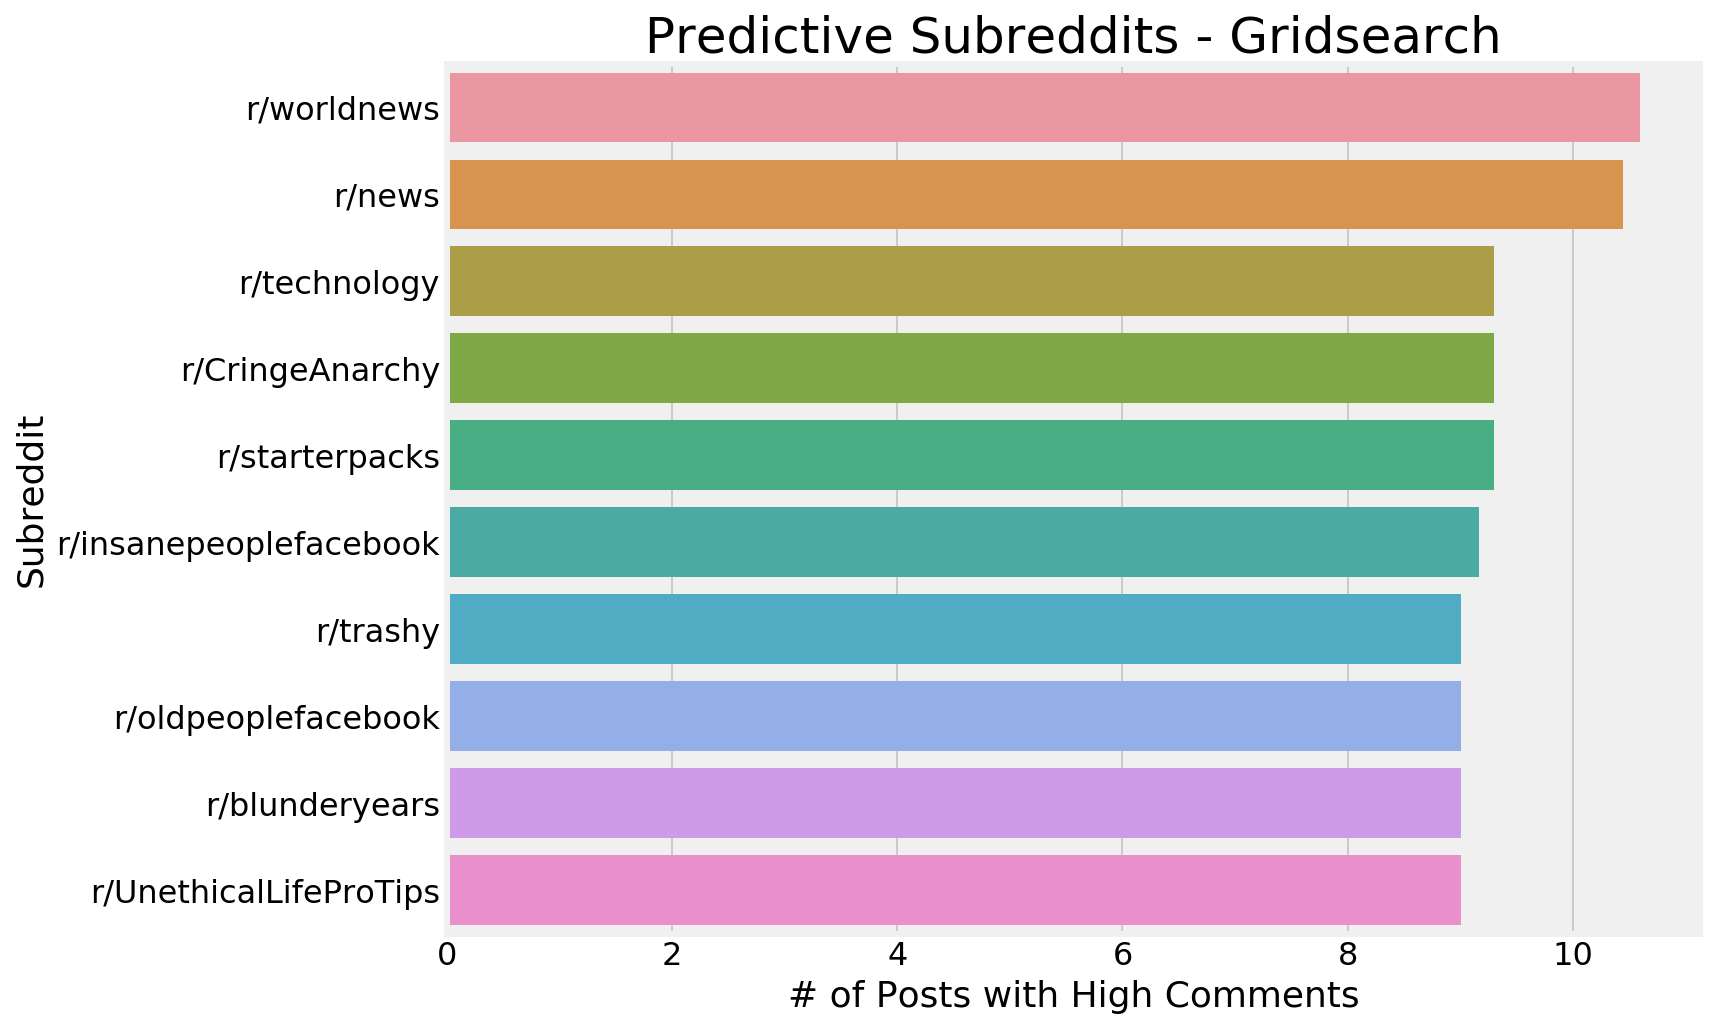

In [376]:
# Plotting bar graph to visualize  

plt.figure(figsize=(10,8))
sns.barplot(x="Coef", y="Subreddit", data=df_subreddit_comparison)
plt.title('Predictive Subreddits - Gridsearch',fontsize=25)
plt.xlabel('# of Posts with High Comments',fontsize=18)
plt.ylabel('Subreddit',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### _Building Confusion Matrix & Accessing Components _

In [377]:
from sklearn.metrics import confusion_matrix as confusion_matrix

# Building Confusion Matrix
confusion_matrix = confusion_matrix(y_test,gs_preds)

# Accessing Components 
tn, fp, fn, tp = confusion_matrix.ravel()

### _Computing Performance Metrics _

In [378]:
accuracy = (tp + tn) / (tn + fp + fn + tp) 
print('         Accuracy: ',accuracy)

misclassification = (fp + fn)/ (tn + fp + fn + tp)  
print('Misclassification: ',misclassification)

sensitivity = tp / (tp + fn)
print('      Sensitivity: ', sensitivity)

specificity = tn / (tn + fp)
print('      Specificity: ',specificity)

precision = tp / (tp + fp)
print('        Precision: ',precision)

         Accuracy:  0.8885375494071146
Misclassification:  0.11146245059288537
      Sensitivity:  0.7554858934169278
      Specificity:  0.9334038054968288
        Precision:  0.7927631578947368


- While Sensitivity has improved by about 4% through grid search optimization, Sensitivty is still < Specificity and the model remains better at predicting posts with low comments.

### _Investigating Coefficient Distribution_
- The majority of model coefficients having negative values further demonstrate the model's ability to predict posts receiving low comments better than posts receiving high comments. 

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 9 Text yticklabel objects>)

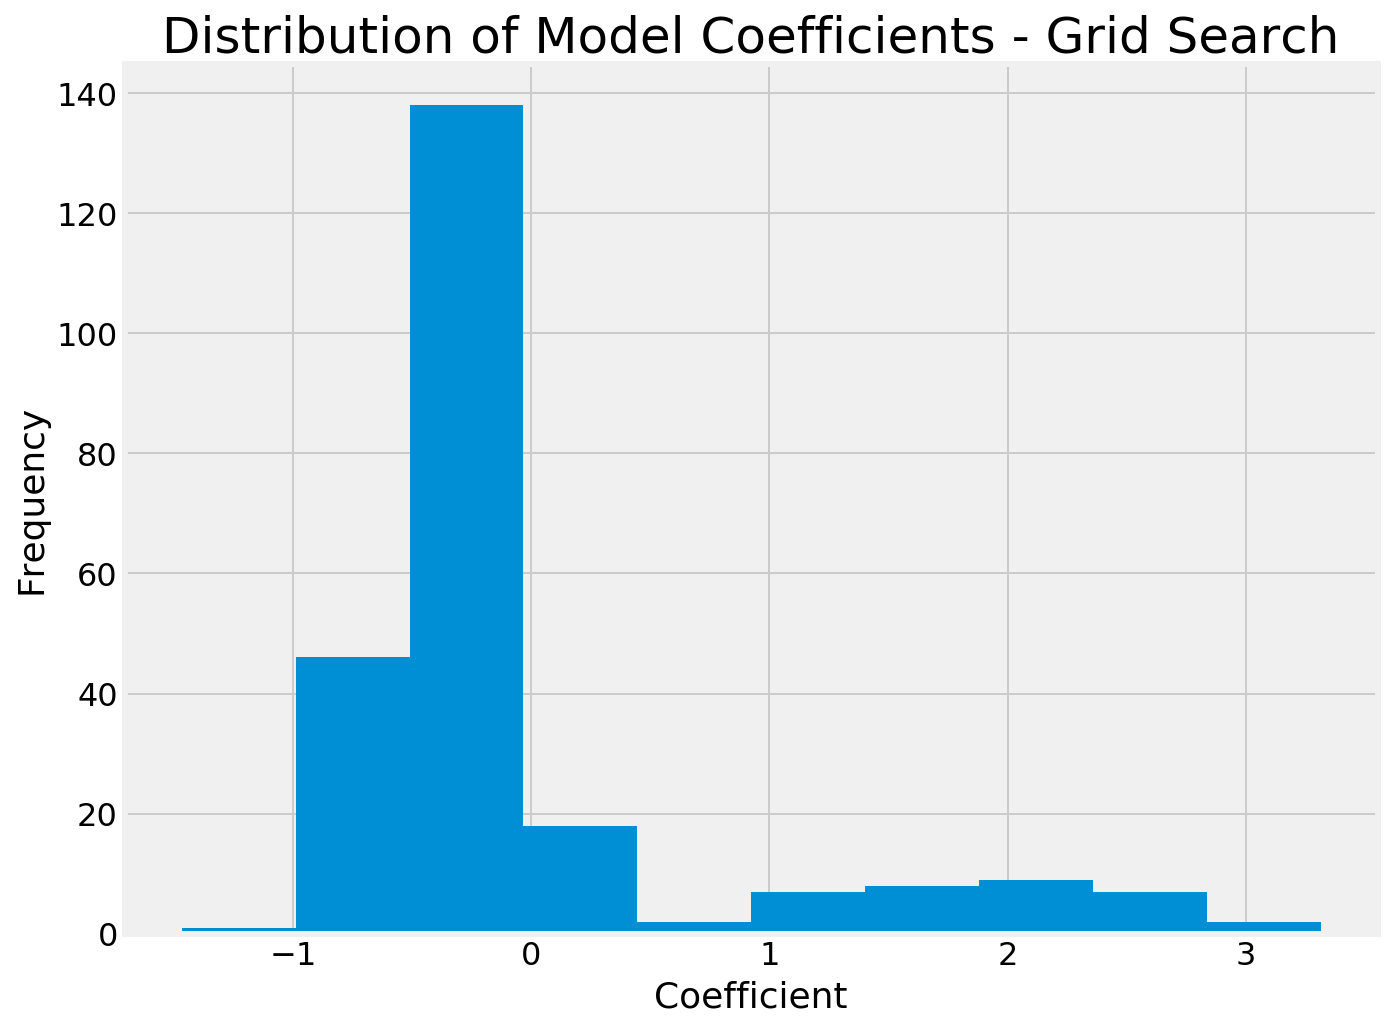

In [379]:
# Plotting bar graph to visualize distribution of model coefficients 

plt.figure(figsize=(10,8))
plt.hist(lr1.coef_[0]) # Accessing model coefficients
plt.title('Distribution of Model Coefficients - Grid Search',fontsize=25)
plt.xlabel('Coefficient',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# 4. Executive Summary 

Executive Summary | What Drives User Interaction on Reddit?

By : Lauren Cable 

INTRODUCTION : 
Reddit is a massive online platform that aggregates social news, web content ratings, and discussions. A user-driven website, the way content is presented relies solely on the up-voting and down-voting of submissions by registered users. Content is organized into categorical boards called Subreddits. Whether it'a a dumb cat video or a riveting political discussion, users are bound to find Subreddits that seem-tailor made for them, evidenced by 500+ million monthly users. In an age where almost all of us consume popular culture via online outlets, utilzing machine learning algorithms to identify what characteristics of a Reddit post that result in the most user interaction is certainly worth discussing.

ABSTRACT : 
The ultimate goal of this analysis was to identify what features of a Reddit post drive user interaction. Unsurprisingly, a web scraper was constructed to extract the following information from each "hot thread" on Reddit.com : title, subreddit, number of comments, and length of time since posting. The model building process sought to improve on a baseline accuracy of 75% by transforming the target variable (Number of Comments) into a binary classification problem and using Natural Language Processing and other classification methods in order to utilize other features as predictor variables. Subreddits were identified as the feature to boast the most predictive power in doing so, but the model was ultimately still more accurate in predicting when a hot thread on Reddit will receive a low number of comments rather than a high number of comments. 

METHODS AND RESULTS : 
Utilizing the Requests and Beautiful Soup libraries in Python, a web scraper was constructed to pull data from Reddit.com and aggregate over 2,500 unique results. Utilizing the HTML structure of the website, functions were written to extract desired information for each post (title, subreddit, length of time since posting, number of comments). The target variable (Number of Comments) was transformed into a binary classication problem utilizing the 75th percentile (418 Commennts) as the cut-off for classes. A baseline accuracy of 75% was determined by investigating class attributes and grabbing the approproate summary statistic. 

- Model 1:
A count vectorizer transformed the 'Title' column into a sparse predictor matrix, which was then fed into a Random Forest Model with English stop words removed. Feature importances were then accessed to identify what title words were most predictive of a Reddit post receiving high comments. The parameters for the count vectorizer were exlpored by way of varying n-gram ranges (contiguous sequence of n items) in order to discover additional predictive word patterns. The Random Forest model utilizing count vectorized title words with an n-gram range of 3 performed best, improving on baseline accuracy by 15%.
- Model 2 :
A dummy variable transformed the 'Subreddit' column into a sparse binary predictor matrix, which was then fed into a Random Forest Model with English stop words removed. Feature importances were then accessed to identify what Subreddits were most predictive of a Reddit post receiving high comments. By investigating attributes of the top 3 most predictive Subreddits - r/worldnews, r/news, r/pics - additional insight was provided into the times since posting strongly correlated with high user interaction. Interaction seem to steadily increase through the 7th hour since posting, then declines fairly steadily. The model improved on baseline accuracy by 13%.
- Model 3 :
A dummy variable transformed the 'Subreddit' column into a sparse binary predictor matrix, which was then fed into a Logistic Regression, resulting in a 17% improvement on baseline accuracy. Perfoming with the most success, additional metrics derived from unraveling the components of a confusion matrix were explored, particularly sensitivty (% of time model predicts high comments when comments are actually high) and specificity (% of time model predicts low comments when comments are actually low). Prior to optimization, sensitivity was 55% and specificity was 99%, meaning the model can more accurately predict low comments. Model optimization aka algorithm tuning, the final step in the machine learning process, was achieved by running a Grid Search on the parameters for the Logistic Regression Model. This strategy builds and evaluates a model for each combination of algorithm parameters specified in a grid. The Grid Search produced a model that improved on the baseline accuracy by 19%. Sensitivity was improved on by 4%, but this figure was still substantially lower than specificity. Plotting model coefficients reveals mainly negative values, futher demonstrating the model's ability to predict low user interaction better than high user interaction. 


RECOMMENDATIONS:
To sidestep the problem of below industry standard sized dataset, run the web scraper frequent and often (each day/every other day for a few weeks) to gather an adequate and varied amount of data. By increasing the dataset's depth, accuracy in predicting the target value (High Comments) will increase. Features that did not perform well in predicting the high number of comments can be used to predict low number of comments. Determining what drives low number of comments could be a beneficial tool in further understanding what affects user interaction as a whole.